# Preprocessing of CM2.6 input for air-sea flux calculation

This notebook executes the following steps:

- Write out a temporary version of the combined dataset
- Coarsen the full dataset
    - Perform sanity checks for the coarsened data
    - Visual check for smoothness
- Filter the full dataset
    

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, filter_inputs_dataset, weighted_coarsen, open_zarr, maybe_write_to_temp_and_reload
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params

In [3]:
fs = gcsfs.GCSFileSystem()
# load global parameters

# TODO 🚨 Put the new verison in a subfolder (so I can delete older stores in batch)
params = get_params('v1.0.0', test=False)

path_temp = params['paths']['CM26']['scratch']
path_output_filter = params['paths']['CM26']['filter']
path_output_coarse = params['paths']['CM26']['coarse']

print(path_temp)
print(path_output_filter)
print(path_output_coarse)

gs://leap-scratch/jbusecke/scale-aware-air-sea/v1.0.0/temp/CM26.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/preprocessed/CM26_filter.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.0/preprocessed/CM26_coarse_50.zarr


In [4]:
# fs.rm(path_temp, recursive=True)
# fs.rm(path_output_filter, recursive=True)
# fs.rm(path_output_coarse, recursive=True)

## Set up a legit dask cluster

In [5]:
import dask
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 100
options.worker_cores = 12

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.scale(50)
client

[ClusterReport<name=prod.9442e2161e904ed8ac74d3c1837bd9d5, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.31fac3f8e42f4954ab14d833319dcc72/status,


## Write out the source data in a temp folder and reload

#TODO: Ideally we would get rid of this step entirely. Lets see how dask gateway performs now.

In [6]:
ds_merged = maybe_write_to_temp_and_reload(fs, path_temp, params['version'])

## Coarsen input fields

In [7]:
ds_coarse = weighted_coarsen(
    ds_merged, 
    {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
    'area_t'
)
ds_coarse

<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dyt           (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 370.3
    geolat_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolon_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht            (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt           (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet           (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean      (xt_ocean) float64 -277.5 -272.5 -267.5 ... 67.5 72.5 77.5
  * yt_ocean      (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    dxt           (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

### Sanity checks for the coarsened data

#### Fine and coarse datasets should preserve the global mean tracer values

Text(0.5, 1.0, 'Global weighted SST average')

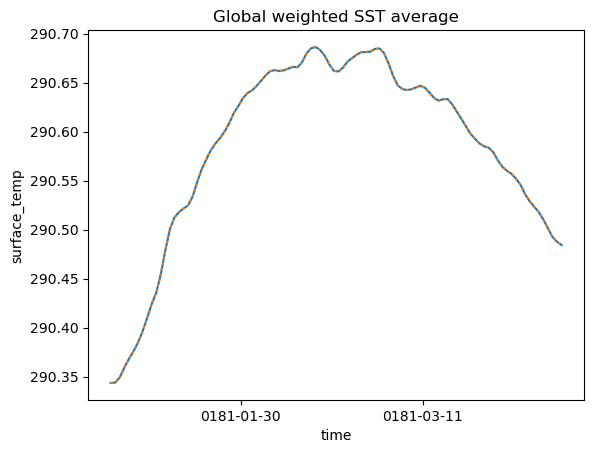

In [8]:
roi = dict(time=slice(0,100))
ds_merged_sample = ds_merged.isel(**roi)
ds_coarse_sample = ds_coarse.isel(**roi)

def w_mean_plot(ds, label, ls):
    da = ds['surface_temp']
    da.weighted(da.area_t).mean(['xt_ocean', 'yt_ocean']).plot(label=label, ls=ls)
    
w_mean_plot(ds_merged_sample, 'fine', '-')
w_mean_plot(ds_coarse_sample, 'coarse', ':')
plt.title('Global weighted SST average')

#### Are eddies visually eliminated?

This is just a visual check for now.

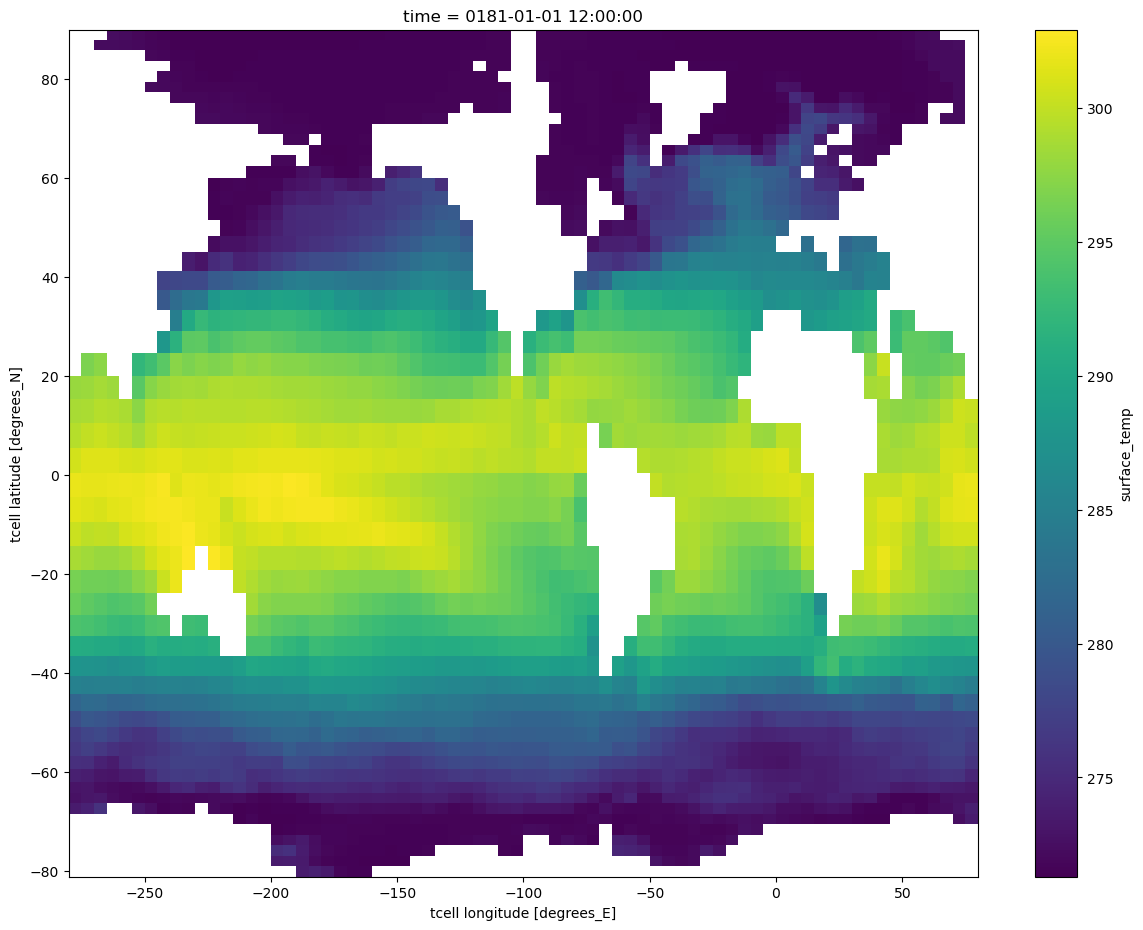

In [9]:
ds_coarse.isel(time=0).surface_temp.plot(size=11)

### Save out the Coarsened Data

In [10]:
ds_save_coarse = ds_coarse
print(f"{ds_save_coarse.nbytes/1e9} GB")
ds_save_coarse.to_zarr(path_output_coarse)

2.499607992 GB


<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -277.5 -272.5 -267.5 ... 67.5 72.5 77.5
  * yt_ocean      (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

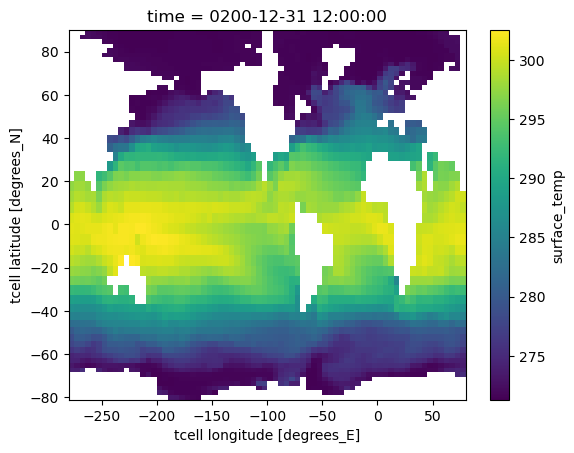

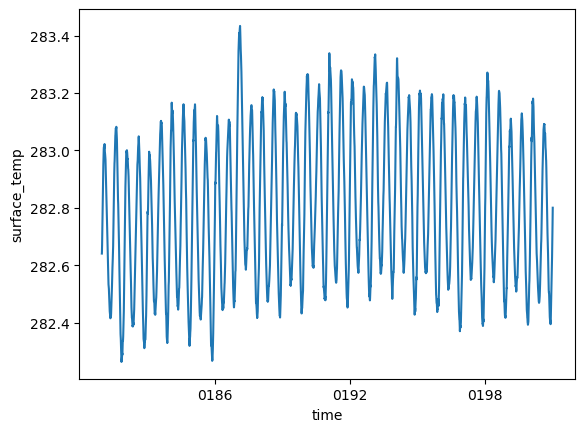

In [11]:
# Check the outputs quickly
ds_reloaded_coarse = open_zarr(path_output_coarse)
display(ds_reloaded_coarse)
plt.figure()
ds_reloaded_coarse.isel(time=-1)['surface_temp'].plot()

plt.figure()
ds_reloaded_coarse.surface_temp.mean(['xt_ocean', 'yt_ocean']).plot()

## Filtered input fields

In [8]:
filter_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']

# filter the whole dataset with the new method
ds_merged_filtered = filter_inputs_dataset(
    ds_merged[filter_vars], 
    ['yt_ocean', 'xt_ocean'], 
    params['filter_scale'], 
    filter_type=params['filter_type'],
)

# add the filtered variables to the original dataset
for var in filter_vars:
    ds_merged[var+'_filtered'] = ds_merged_filtered[var]
    
# also rebuild a second relative wind from only ocean filtered velocities
ds_merged['u_relative_filtered_ocean_only'] = ds_merged['u_ref'] - ds_merged['u_ocean_filtered']
ds_merged['v_relative_filtered_ocean_only'] = ds_merged['v_ref'] - ds_merged['v_ocean_filtered']

ds_merged['u_relative_filtered_atmos_only'] = ds_merged['u_ref_filtered'] - ds_merged['u_ocean']
ds_merged['v_relative_filtered_atmos_only'] = ds_merged['v_ref_filtered'] - ds_merged['v_ocean']

ds_merged

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 0.0 0.0 ... 0.0
    dxt                             (yt_ocean, xt_ocean) float64 1.719e+03 .....
    dyt                             (yt_ocean, xt_ocean) float64 4.697e+03 .....
    geolat_t                        (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
    geolon_t                        (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
    ht                              (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
    kmt                             (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
    wet                             (yt_ocean, xt_ocean) float64 0.0 0.0 ... 0.0
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/25)
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean                         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Some sanity checks with the data before large batch save

#### Check that the nanmask is uniform across variables

All variables should have the same missing values. Previous versions had different nans for vel and tracers.
See [here](https://github.com/ocean-transport/scale-aware-air-sea/issues/46) for details.

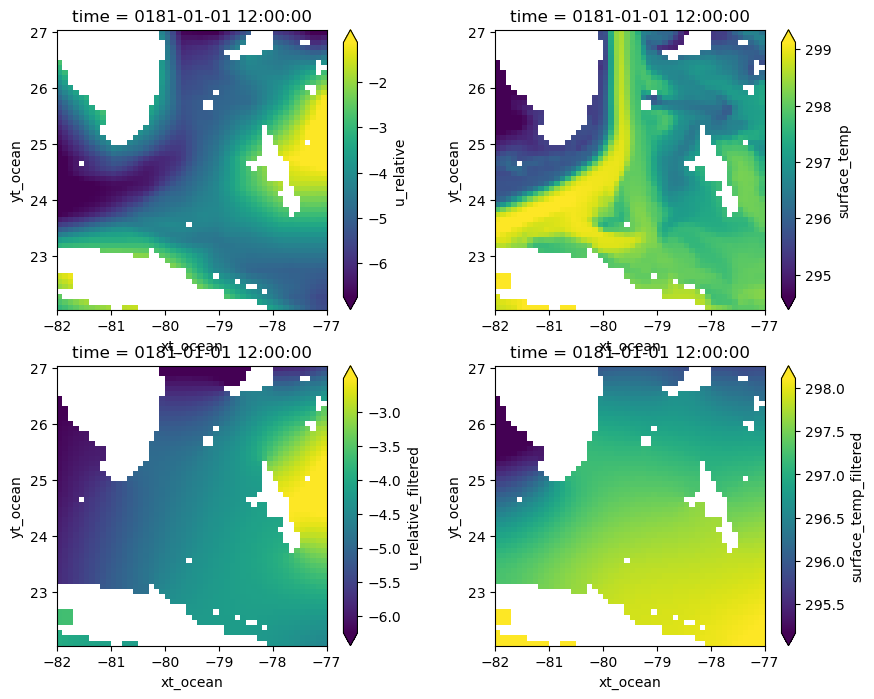

In [9]:
roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))
test_ds = ds_merged.isel(time=0).sel(**roi).load()

plt.figure(figsize=[10,8])
for i, var in enumerate(['u_relative', 'surface_temp', 'u_relative_filtered', 'surface_temp_filtered']):
    plt.subplot(2,2,i+1)
    test_ds[var].plot(robust=True)
plt.subplots_adjust(wspace=0.3)

In [10]:
# prune dataset for saving
keep_vars = [
    'slp_filtered', 'surface_temp_filtered',
    'u_relative_filtered','v_relative_filtered',
    'u_relative_filtered_ocean_only','v_relative_filtered_ocean_only',
    'u_relative_filtered_atmos_only','v_relative_filtered_atmos_only',
    't_ref_filtered', 'q_ref_filtered'
]
ds_save_smooth = ds_merged[keep_vars]
print(f"{ds_save_smooth.nbytes/1e12} TB")

2.84065066884 TB


### Save out the Filtered Data

In [11]:
ds_save_smooth.to_zarr(path_output_filter)

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_filtered                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_filtered           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

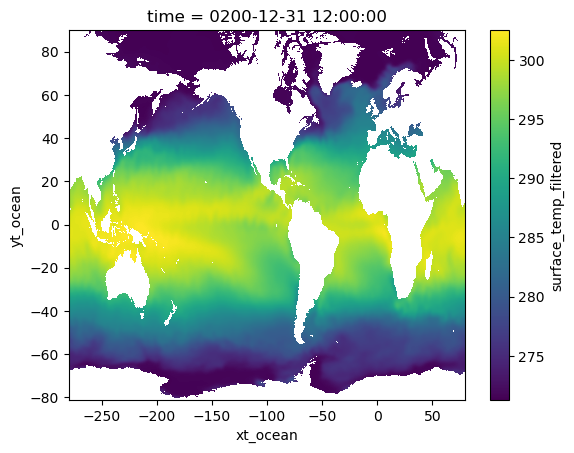

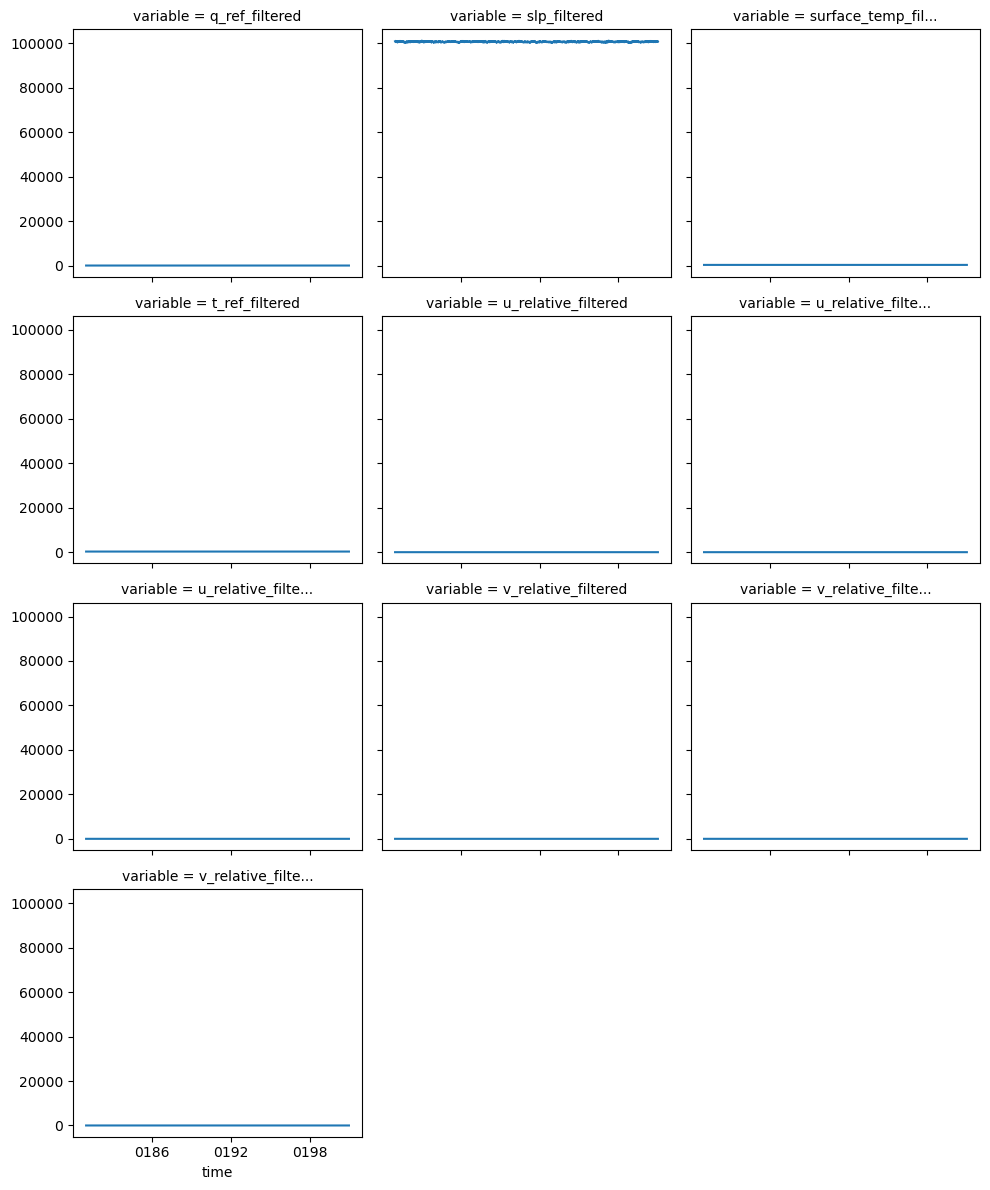

In [12]:
ds_reloaded_filter = open_zarr(path_output_filter)
display(ds_reloaded_filter)

ds_reloaded_filter.surface_temp_filtered.isel(time=-1).plot()

da_reloaded_filter = ds_reloaded_filter.to_array()
da_reloaded_filter.mean(['xt_ocean','yt_ocean']).plot(col='variable', col_wrap=3)

In [17]:
cluster.shutdown()